# Module 8B

## Read two example organelle shapes from a CellOrganizer model and create a movie by interpolating between them in the shape space.

In [1]:
#import packages
import h5py
import numpy as np

from pathlib import Path
from cellorganizer.tools import SPHARMparameterization2image, SPHARMparameterization2mesh
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

In [2]:
def vinterpolate(t, vector_a, vector_b):
# t is from interval <0, 1>
    return (1 - t) * vector_a + t * vector_b

In [3]:
def plotamesh(mesh_mat,fig):
    # vertices
    v = mesh_mat['Zvert']
    #print(len(v))
    # faces
    f = mesh_mat['fs']-1
    #print(len(f))

    # assign each face a "color number" matching its average z coordinate
    C=np.empty(len(f))
    for itup in range(len(f)):
        C[itup]=np.mean(v[f[itup]], axis=0)[2]
    # an alternative is to assign a "color number" equal to the index of the face
    #C = np.array(list(range(len(f))))
    # normalize the color numbers to range 0-1
    norm = plt.Normalize(C.min(), C.max())
    # assign a color to each face
    colors = plt.cm.viridis(norm(C))

    #fig = plt.figure()
    ax = fig.add_subplot(projection="3d")

    pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="gray")
    ax.add_collection(pc)
    vmins = np.amin(v, axis=0)
    vmaxs = np.amax(v, axis=0)
    ax.set_xlim(vmins[0], vmaxs[0])
    ax.set_ylim(vmins[1], vmaxs[1])
    ax.set_zlim(vmins[2], vmaxs[2])

    elevation = 45
    azimuth = 330
    ax.view_init(elevation, azimuth)
    #plt.show()

# read an organelle shape model

In [4]:
f = h5py.File('/home/murphylab/cellorganizer/local/models/mito_GT_model.mat', 'r')

In [5]:
# Read shape information from the model
model = f['model']
proteinModel = model['proteinModel']
spharm_obj_model = proteinModel['spharm_obj_model']
cellShapeModel = spharm_obj_model['cellShapeModel']
max_deg_dataset = cellShapeModel['max_deg']
print(type(max_deg_dataset))
print(max_deg_dataset)
max_deg = 31
# cell_params has full SPHARM descriptors for each object (#objects,)
cell_params=cellShapeModel['cell_params']
print(cell_params.shape)

<class 'h5py._hl.dataset.Dataset'>
<HDF5 dataset "max_deg": shape (1, 1), type "<f8">
(2551, 3, 1024)


In [6]:
params1 = {}
params2 = {}
params1['deg'] = max_deg
params2['deg'] = max_deg
# invert the order of the descriptors and convert from 'real','imag' pairs to complex
# (this is due to the difference in the way Matlab and python treat complex)
fv1 = np.transpose(cell_params[0,:,:],(1, 0))
params1['fvec']=np.vectorize(complex)(fv1['real'], fv1['imag'])
print(params1['fvec'].shape)
fv2 = np.transpose(cell_params[1,:,:],(1, 0))
params2['fvec']=np.vectorize(complex)(fv2['real'], fv2['imag'])
print(params2['fvec'].shape)
# print full descriptors for the first two objects
print(params1['fvec'][0,:])
print(params2['fvec'][0,:])

(1024, 3)
(1024, 3)
[137.71758697+2.67987597e-18j 129.63847094+2.22227868e-17j
  35.82448732+1.19865151e-17j]
[12.21907341-8.78673658e-19j 12.36426735-1.31801049e-18j
 16.66105342+4.55027430e-19j]


# SPHARM PARAMS 2 MESH #

CellOrganizer v2.10 (MATLAB RO2019a)


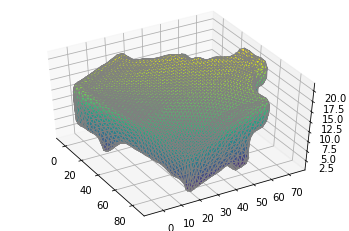

In [7]:
# convert descriptors to mesh and generate plot for the first object
mesh_mat1 = SPHARMparameterization2mesh(params1)
#print(mesh_mat1)
plotamesh(mesh_mat1,plt.figure())

CellOrganizer v2.10 (MATLAB RO2019a)


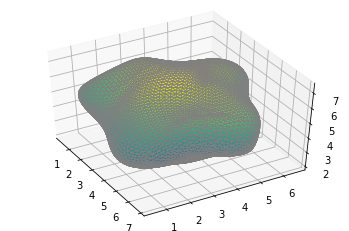

In [8]:
# convert descriptors to mesh and generate plot for the second object
mesh_mat2 = SPHARMparameterization2mesh(params2)
plotamesh(mesh_mat2,plt.figure())

## reduce dimensionality of descriptors using PCA
### since descriptors are two dimensional complex numbers need to flatten before PCA
## Note constant for number of PCs to keep (increasing provides better reconstruction)

In [9]:
from sklearn.decomposition import PCA
# flatten spharm descriptors and convert from complex to concatenated reals
cps=cell_params.shape
print(cps)
flatparams=np.reshape(cell_params,(cps[0],cps[1]*cps[2]))
print(flatparams.shape)
print(flatparams[0,0:3])
flatreal=np.concatenate((flatparams['real'],flatparams['imag']), axis=1)
print(flatreal.shape)
print(flatreal.dtype)
# make the PCA model and convert flattened descriptors to compressed and back for testing
# >>> set the number of PCs to keep here
pca = PCA(n_components=100)
reducedflat=pca.fit_transform(flatreal)
print(reducedflat.shape)
# convert back to flattened descriptors
reconflat=pca.inverse_transform(reducedflat)
print(reconflat.shape)
print(reconflat[0,0],reconflat[0,3072])
print(flatreal[0,0],flatreal[0,3072])
print(reconflat[0,0],reconflat[0,3072])
# now reverse previous steps - one way to convert back to complex
reconsplit=np.reshape(reconflat,(cps[0],-1,2))
reconcplx=np.vectorize(complex)(reconsplit[:,:,0], reconsplit[:,:,1])
print(reconcplx.shape)
print(reconcplx.dtype)
print(reconcplx[0,0])
# another way
cps12=cps[1]*cps[2]
reconr=reconflat[:,0:cps12]
reconi=reconflat[:,cps12:cps12*2]
print(reconr.shape, reconi.shape)
print(reconr[0,0:3],reconi[0,0:3])
reconcplx=reconr+1j*reconi
print(reconcplx.shape)
print(reconcplx.dtype)
print(reconcplx[0,0])
# convert back to 3,
reconshaped=np.reshape(reconcplx,(cps[0],cps[1],cps[2]))
print(reconshaped.shape)
print(reconshaped.dtype)
print(cell_params[0,:,0])
print(reconshaped[0,:,0])
print(params1['fvec'][0,:])

(2551, 3, 1024)
(2551, 3072)
[(137.71758697,  2.67987597e-18) (  2.06817627, -3.53227995e+00)
 ( 88.32004543, -9.19604752e-17)]
(2551, 6144)
float64
(2551, 100)
(2551, 6144)
137.71747656377332 -1.6292192519067004e-14
137.71758696598525 2.679875969169513e-18
137.71747656377332 -1.6292192519067004e-14
(2551, 3072)
complex128
(137.71747656377332+2.062394151713575j)
(2551, 3072) (2551, 3072)
[137.71747656   2.06239415  88.31910517] [-1.62921925e-14 -3.54977594e+00 -3.25448954e-15]
(2551, 3072)
complex128
(137.71747656377332-1.6292192519067004e-14j)
(2551, 3, 1024)
complex128
[(137.71758697, 2.67987597e-18) (129.63847094, 2.22227868e-17)
 ( 35.82448732, 1.19865151e-17)]
[137.71747656-1.62921925e-14j 129.63818599+3.96860438e-14j
  35.82182721+1.33111543e-14j]
[137.71758697+2.67987597e-18j 129.63847094+2.22227868e-17j
  35.82448732+1.19865151e-17j]


## plot the mesh for the descriptors reconstructed from PCs

[137.71747656-1.62921925e-14j 129.63818599+3.96860438e-14j
  35.82182721+1.33111543e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)


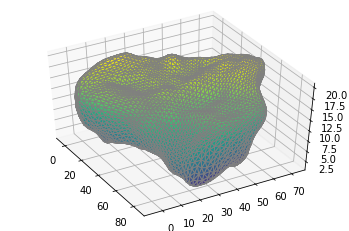

In [10]:
params3 = {}
params3['deg'] = max_deg
params3['fvec'] = np.transpose(reconshaped[0,:,:],(1,0))
print(params3['fvec'][0,])
mesh_mat3 = SPHARMparameterization2mesh(params3)
plotamesh(mesh_mat3,plt.figure())

## now illustrate how to morph one shape into another (just show a few steps)
## this morphing process is also referred to as shape evolution
### use the PC representation for interpolation

[137.71747656-1.62921925e-14j 129.63818599+3.96860438e-14j
  35.82182721+1.33111543e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)
[106.34293573-1.12993010e-14j 100.31970785+2.60696672e-14j
  31.03150346+1.01414790e-14j]
CellOrganizer v2.10 (MATLAB RO2019a)
[74.9683949 -6.30640948e-15j 71.00122971+1.24532907e-14j
 26.2411797 +6.97180374e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[43.59385407-1.31351796e-15j 41.68275157-1.16308586e-15j
 21.45085594+3.80212844e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[12.21931324+3.67937355e-15j 12.36427343-1.47794624e-14j
 16.66053219+6.32453134e-16j]
CellOrganizer v2.10 (MATLAB RO2019a)


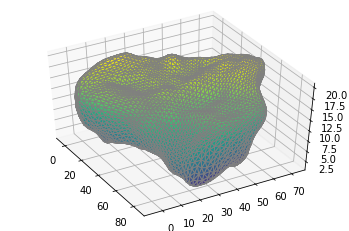

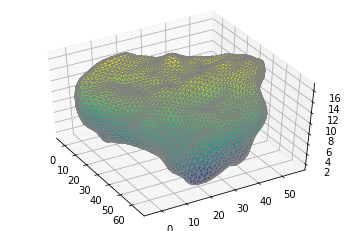

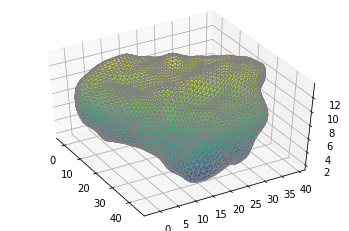

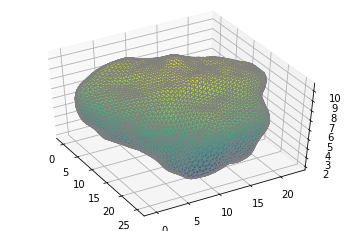

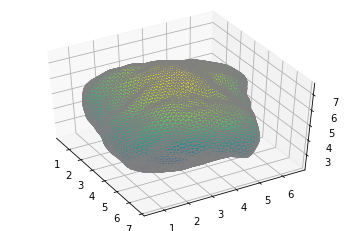

In [11]:
startingshape = 0
endingshape = 1
nsteps = 5
for istep in range(0,nsteps):
    reducedi = vinterpolate(istep/(nsteps-1), reducedflat[startingshape,:], reducedflat[endingshape,:])
    fulli = pca.inverse_transform(reducedi)
    reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
    reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
    paramsi = {}
    paramsi['deg'] = max_deg
    paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
    print(paramsi['fvec'][0,])
    mesh_mati = SPHARMparameterization2mesh(paramsi)
    plotamesh(mesh_mati,plt.figure())

## now make a movie morphing first shape into second shape

[23.12454556+3.24527303e-15j 24.50544323-4.67664485e-14j
 17.06151962+3.21370397e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[22.33235278+2.80547017e-15j 23.92666097-4.33566114e-14j
 16.82488398+3.05297647e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[21.54016   +2.36566730e-15j 23.34787871-3.99467743e-14j
 16.58824835+2.89224896e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[20.74796722+1.92586444e-15j 22.76909645-3.65369372e-14j
 16.35161272+2.73152146e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[19.95577444+1.48606157e-15j 22.1903142 -3.31271001e-14j
 16.11497708+2.57079396e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[19.16358166+1.04625871e-15j 21.61153194-2.97172630e-14j
 15.87834145+2.41006645e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[18.37138888+6.06455843e-16j 21.03274968-2.63074259e-14j
 15.64170581+2.24933895e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[17.5791961 +1.66652979e-16j 20.45396743-2.28975888e-14j
 15.40507018+2.08861145e-15j]
CellOrganizer v2.10 (MATLAB RO2019a)
[16.7870

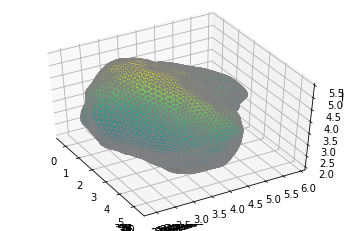

In [12]:
import matplotlib
import matplotlib.animation as manimation
import os

folder_name = 'Module8B'
topdir = "/home/murphylab/cellorganizer/local/results"
outputdir = topdir + "/" + folder_name
if not os.path.exists(topdir):
    os.makedirs(topdir)
os.chdir(topdir)
os.system("ls")
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
os.chdir(outputdir)
os.system("ls")

matplotlib.use("Agg")

FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Example shape evolution', artist='CellOrganizer',
                comment='Created by Module 8B')
writer = FFMpegWriter(fps=15, metadata=metadata)

fig = plt.figure()

startingshape = 2
endingshape = 3
nsteps = 20
with writer.saving(fig, "ExampleOrganelleShapeEvolution.mp4", 100):
    for istep in range(0,nsteps):
        reducedi = vinterpolate(istep/(nsteps-1), reducedflat[startingshape,:], reducedflat[endingshape,:])
        fulli = pca.inverse_transform(reducedi)
        reconcplxi=fulli[0:cps12]+1j*fulli[cps12:cps12*2]
        reconshapedi=np.reshape(reconcplxi,(cps[1],cps[2]))
        paramsi = {}
        paramsi['deg'] = max_deg
        paramsi['fvec'] = np.transpose(reconshapedi[:,:],(1,0))
        print(paramsi['fvec'][0,])
        mesh_mati = SPHARMparameterization2mesh(paramsi)
        plotamesh(mesh_mati,fig)
        writer.grab_frame()
#writer.finish()

In [13]:
from IPython.display import Video
video_path='ExampleOrganelleShapeEvolution.mp4'
Video(video_path, width=640, height=360, embed=True)